# CICIDS2017

Gerekli olan kütüphanelerin eklenmesi:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, Imputer,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense 
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import RandomForestRegressor


İlk olarak elimde bulunan datasette kullanmak istediğim saldırı türlerini belirledim. Bu saldırı türleri DoS DDoS ve Port Scan.
Datasetten bu üç saldırı trafiğini ve BENIGN(İyi huylu) trafiğini kapsayan bir .csv dosyası oluşturdum.
Dataset dosyasından verinin okunması,DoS saldırılarının birleştirilmesi,gürültünün azaltılması, NaN değerlerin bulunup column ortalamasının atanması ,veri tiplerinin int64 ve float64 yapılma aşaması:

In [ ]:
df=pd.read_csv('combined2.csv')
df_value=df[' Label'].value_counts()
df[' Label']=df[' Label'].apply({'DoS Hulk':'DoS', 'DoS GoldenEye':'DoS','DoS Slowhttptest':'DoS','DoS slowloris':'DoS' ,'BENIGN':'BENIGN' ,'DDoS':'DDoS', 'PortScan':'PortScan'}.get)
df2=df.drop_duplicates() 
df2_value=df2[' Label'].value_counts()
datatype=df2.dtypes # veritiplerine bakılarak object olarak algılanan numeric attributelaerin float64 yapılması
df2['Flow Bytes/s']=df2['Flow Bytes/s'].astype('float64')
df2[' Flow Packets/s']=df2[' Flow Packets/s'].astype('float64')
NaN_values=df2.isnull().sum() #gürültü azaldıktan sonra NaN değere sahip attributun tespit edilmesi
df2['Flow Bytes/s'].fillna(df2['Flow Bytes/s'].mean(),inplace=True)#'Flow Bytes/s' attributenin ortalama ile Nan değerlerinin doldurulması.
print('Datasetin ilk okunduğu hali: \n',df_value)
print('Datasetin ilk (row,Column) sayısı: {} '.format(df.shape))
print('Datasetin Labelindeki DoS daldırılarının birleştirilmesi ve gürültünün azaltılması:\n',df2_value)
print('Datasetin son (row,Column) sayısı: {} '.format(df2.shape))
#pd.options.mode.chained_assignment = None 

Datasetin son halinin .csv formatına getirilmesi

df2.to_csv('dataset.csv', sep=',', encoding='utf-8', index=False)

Bundan sonraki adımlarda yeni oluşturmuş olduğum dataset.csv dosyasını okuyarak devam ettim.

## dataset.csv dosyası ile yaptıklarım

### dataset.csv dosyasının okunması , datasetin görüntülenmesi:

In [2]:
dataset=pd.read_csv('dataset.csv')
dataset

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Algoritmaların ikili gruplar halinde uygulanması (DoS,BENIGN),(DDoS,BENIGN)(PortScan,BENIGN);
ilk olarak mevcut olan dataframeden belli Labellara sahip rowları alarak yeni dataframeler oluşturdum.

### DoS ve BENIGN içeren dataframe'in oluşturulması:

In [3]:
DoS_df1=dataset[dataset[' Label']=='BENIGN']
DoS_df=DoS_df1.append(dataset[dataset[' Label']=='DoS'])
DoS_df
#823.716x79 

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### DDoS ve BENIGN içeren dataframe'in oluşturulması:

In [4]:
DDoS_df1=dataset[dataset[' Label']=='BENIGN']
DDoS_df=DDoS_df1.append(dataset[dataset[' Label']=='DDoS'])
DDoS_df
#757096x79

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### PortScan ve BENIGN  bulunan dataframe'in oluşturulması

In [5]:
PortScan_df1=dataset[dataset[' Label']=='BENIGN']
PortScan_df=PortScan_df1.append(dataset[dataset[' Label']=='PortScan'])
PortScan_df
#719893 rows × 79 columns


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Saldırı trafiğinin anormal olarak etiketlemesi ve BENIGN olan trafiğin Normal olarak etiketlenip dataframe'in oluşturulması:

In [6]:
NA_df=dataset
NA_df[' Label']=NA_df[' Label'].apply({'DoS':'Anormal','BENIGN':'Normal' ,'DDoS':'Anormal', 'PortScan':'Anormal'}.get)
NA_df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
5,54871,1022,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
6,54925,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
7,54925,42,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
8,9282,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal
9,55153,4,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal


KNIME'da kullanabilmek için oluşturduğum datasetlerin csv'lerini oluşturdum.

DoS_df.to_csv('DoS_dataset.csv', sep=',', encoding='utf-8', index=False)

DDoS_df.to_csv('DDoS_dataset.csv', sep=',', encoding='utf-8', index=False)

PortScan_df.to_csv('PortScan_dataset.csv', sep=',', encoding='utf-8', index=False)

NA_df.to_csv('NormalAnormal_dataset.csv', sep=',', encoding='utf-8', index=False)

NaN_values1=DoS_df.isnull().sum()
NaN_values2=DDoS_df.isnull().sum()
NaN_values3=PortScan_df.isnull().sum()
NaN_values4=NA_df.isnull().sum()
NaN_values1
NaN_values2
NaN_values3
NaN_values4
NAN value var mı diye baktım yok.

## Algoritmalar için yazdığım metodlar

In [7]:
def train_test_dataset(df):
    labelencoder = LabelEncoder()
    df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
    X = df.drop([' Label'],axis=1) 
    y = df.iloc[:, -1].values.reshape(-1,1)
    y=np.ravel(y)
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0, stratify = y)
    return  X_train, X_test, y_train, y_test

In [8]:
def RandomForest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state = 0)
    imputer = Imputer(missing_values="NaN", strategy = "mean")
    imputer = imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
    rf_score=rf.score(X_test,y_test)
    y_predict=rf.predict(X_test)
    y_true=y_test
    print('Random Forest Accuracy:'+ str(rf_score))
    precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
    print('Random Forest precision_recall_fscore:'+(str(precision))+(str(recall))+(str(fscore)))
    
    cm=confusion_matrix(y_true,y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    return rf_score,precision,recall,fscore,none
    

In [9]:
def DecisionTree(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier(random_state = 0)
    imputer = Imputer(missing_values="NaN", strategy = "mean")
    imputer = imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    dt.fit(X_train, y_train)
    score=dt.score(X_test,y_test)
    print('Decision Tree Accuracy:'+ str(score))
   # print('Decision Tree Accuracy2:'+ str(accuracy_score(y_test, y_predict)))
    y_predict=dt.predict(X_test)
    y_true=y_test
    precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
    print('Decision Tree precision_recall_fscore:'+(str(precision))+(str(recall))+(str(fscore)))
    cm=confusion_matrix(y_true,y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    return score,precision,recall,fscore,none

In [10]:
def kNN(X_train, X_test, y_train, y_test):
    knn=KNeighborsClassifier(n_neighbors=5)
    imputer = Imputer(missing_values="NaN", strategy = "mean")
    imputer = imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    knn.fit(X_train,y_train) 
    prediction=knn.predict(X_test)
    score=knn.score(X_test,y_test)
    print("5 nn score:"+ str(score))
    y_predict=knn.predict(X_test)
    y_true=y_test
    precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
    print('5nn precision_recall_fscore:'+(str(precision))+(str(recall))+(str(fscore)))
    cm=confusion_matrix(y_true,y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    return score,precision,recall,fscore,none
    

In [11]:
def SVM(X_train, X_test, y_train, y_test):
    svclassifier = SVC(kernel='linear')  
    imputer = Imputer(missing_values="NaN", strategy = "mean")
    imputer = imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    svclassifier.fit(X_train, y_train) 
    print("SVM Classification Accuracy:"+ str(svclassifier.score(X_test,y_test)))
    y_predict = svclassifier.predict(X_test)  
    y_true=y_test
    cm=confusion_matrix(y_true,y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

In [12]:
def build_classifier(X_train):
    def bm():
        classifier = Sequential() # initialize neural network
        classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
        classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))              
       # classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'softmax'))
        lr=.003
        adam0=Adam(lr=lr)

        classifier.compile(optimizer =adam0, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return classifier
    return bm

In [13]:
def ANN(X_train, X_test, y_train, y_test):
    y_ = to_categorical(y_train)
    y_t=to_categorical(y_test)
    estimator  = KerasClassifier(build_fn = build_classifier(X_train), epochs = 5)
    accuracies = cross_val_score(estimator, X = X_train, y = y_, cv = 3)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))
    

In [14]:
def feature_selection(df):
    feature=(df.drop([' Label'],axis=1)).columns.values
    labelencoder = LabelEncoder()
    df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
    X = df.drop([' Label'],axis=1) 
    Y = df.iloc[:, -1].values.reshape(-1,1)
    Y=np.ravel(Y)
    imputer = Imputer(missing_values="NaN", strategy = "mean")
    imputer = imputer.fit(X)
    X = imputer.transform(X)
    rf = RandomForestRegressor()
    rf.fit(X, Y)
    print ("Features sorted by their score:")
    print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature), reverse=True))

## Feature

In [15]:
feature_selection(dataset)

Features sorted by their score:
[(0.4612, ' Bwd Packet Length Std'), (0.2906, ' ECE Flag Count'), (0.1242, ' Bwd URG Flags'), (0.037, ' Subflow Bwd Packets'), (0.0325, ' Destination Port'), (0.011, ' Min Packet Length'), (0.0079, ' Bwd Packets/s'), (0.0069, ' Flow IAT Min'), (0.0058, ' min_seg_size_forward'), (0.0039, 'Bwd IAT Total'), (0.003, ' Subflow Bwd Bytes'), (0.0027, ' Flow Packets/s'), (0.002, ' Flow IAT Std'), (0.0011, ' Fwd Packet Length Std'), (0.0008, ' PSH Flag Count'), (0.0007, 'Fwd Packets/s'), (0.0006, 'Subflow Fwd Packets'), (0.0006, ' SYN Flag Count'), (0.0006, ' Fwd IAT Min'), (0.0006, ' Bwd IAT Std'), (0.0005, ' RST Flag Count'), (0.0004, 'Fwd IAT Total'), (0.0004, ' Total Backward Packets'), (0.0004, ' Fwd URG Flags'), (0.0004, ' Fwd Packet Length Max'), (0.0003, 'Flow Bytes/s'), (0.0003, ' Fwd Packet Length Min'), (0.0003, ' Fwd IAT Mean'), (0.0003, ' Flow IAT Max'), (0.0002, 'Total Length of Fwd Packets'), (0.0002, ' Total Length of Bwd Packets'), (0.0002, ' Sub

[(0.4612, ' Bwd Packet Length Std'), (0.2906, ' ECE Flag Count'), (0.1242, ' Bwd URG Flags'), (0.037, ' Subflow Bwd Packets'), (0.0325, ' Destination Port'), (0.011, ' Min Packet Length'), (0.0079, ' Bwd Packets/s'), (0.0069, ' Flow IAT Min'), (0.0058, ' min_seg_size_forward'), (0.0039, 'Bwd IAT Total'), (0.003, ' Subflow Bwd Bytes'), (0.0027, ' Flow Packets/s'), (0.002, ' Flow IAT Std'), (0.0011, ' Fwd Packet Length Std'), (0.0008, ' PSH Flag Count'), (0.0007, 'Fwd Packets/s'), (0.0006, 'Subflow Fwd Packets'), (0.0006, ' SYN Flag Count'), (0.0006, ' Fwd IAT Min'), (0.0006, ' Bwd IAT Std'), (0.0005, ' RST Flag Count'), (0.0004, 'Fwd IAT Total'), (0.0004, ' Total Backward Packets'), (0.0004, ' Fwd URG Flags'), (0.0004, ' Fwd Packet Length Max'), (0.0003, 'Flow Bytes/s'), (0.0003, ' Fwd Packet Length Min'), (0.0003, ' Fwd IAT Mean'), (0.0003, ' Flow IAT Max'), (0.0002, 'Total Length of Fwd Packets'), (0.0002, ' Total Length of Bwd Packets'), (0.0002, ' Subflow Fwd Bytes'), (0.0002, ' Fwd Header Length'), (0.0002, ' Flow IAT Mean'), (0.0002, ' Flow Duration'), (0.0002, ' Down/Up Ratio'), (0.0002, ' CWE Flag Count'), (0.0002, ' Bwd Header Length'), (0.0001, 'Bwd Packet Length Max'), (0.0001, 'Bwd Avg Bulk Rate'), (0.0001, ' Fwd Packet Length Mean'), (0.0001, ' Fwd IAT Std'), (0.0001, ' Bwd Packet Length Min'), (0.0001, ' Bwd Packet Length Mean'), (0.0001, ' Avg Fwd Segment Size'), (0.0001, ' Average Packet Size'), (0.0, 'Init_Win_bytes_forward'), (0.0, 'Idle Mean'), (0.0, 'Fwd PSH Flags'), (0.0, 'Fwd Avg Bytes/Bulk'), (0.0, 'FIN Flag Count'), (0.0, 'Active Mean'), (0.0, ' act_data_pkt_fwd'), (0.0, ' URG Flag Count'), (0.0, ' Total Fwd Packets'), (0.0, ' Packet Length Variance'), (0.0, ' Packet Length Std'), (0.0, ' Packet Length Mean'), (0.0, ' Max Packet Length'), (0.0, ' Init_Win_bytes_backward'), (0.0, ' Idle Std'), (0.0, ' Fwd IAT Max'), (0.0, ' Fwd Header Length.1'), (0.0, ' Fwd Avg Packets/Bulk'), (0.0, ' Fwd Avg Bulk Rate'), (0.0, ' Bwd PSH Flags'), (0.0, ' Bwd IAT Min'), (0.0, ' Bwd IAT Mean'), (0.0, ' Bwd IAT Max'), (0.0, ' Bwd Avg Packets/Bulk'), (0.0, ' Bwd Avg Bytes/Bulk'), (0.0, ' Avg Bwd Segment Size'), (0.0, ' Active Std'), (0.0, ' Active Min'), (0.0, ' Active Max'), (0.0, ' ACK Flag Count')]

Train ve Test datasetlerinin tüm dataframler için oluşturulması

In [16]:
DoSX_train, DoSX_test, DoSy_train, DoSy_test=train_test_dataset(DoS_df) 
DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test=train_test_dataset(DDoS_df)
PS_X_train,PS_X_test,PS_y_train, PS_y_test=train_test_dataset(PortScan_df)
NA_X_train, NA_X_test, NA_y_train, NA_y_test=train_test_dataset(NA_df)

### DoS ve BENIGN içeren dataframe için algorimalar:

Random Forest Accuracy:0.9992715941970338
Random Forest precision_recall_fscore:0.99927157769210310.99927159419703380.9992715855820445


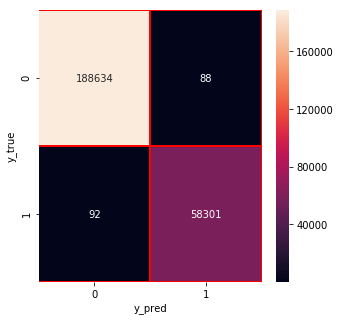

In [17]:
dosrf_score,dosrf_precision,dosrf_recall,dosrf_fscore,none=RandomForest(DoSX_train, DoSX_test, DoSy_train, DoSy_test)

Decision Tree Accuracy:0.9995670032171257
Decision Tree precision_recall_fscore:0.99956704415759030.99956700321712570.9995670198569627


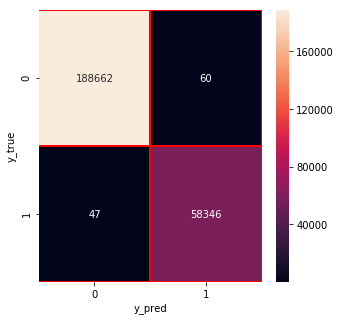

In [18]:
dosdt_score,dosdt_precision,dosdt_recall,dosdt_fscore,none=DecisionTree(DoSX_train, DoSX_test, DoSy_train, DoSy_test)

5 nn score:0.9949173461748578
5nn precision_recall_fscore:0.99492979653577840.99491734617485780.994921687032628


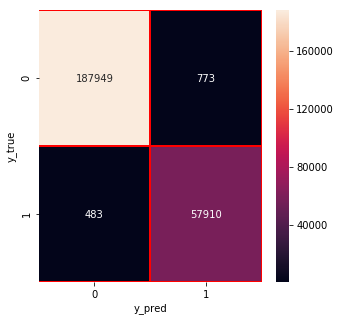

In [19]:
dosKnn_score,dosKnn_precision,dosKnn_recall,dosKnn_fscore,none=kNN(DoSX_train, DoSX_test, DoSy_train, DoSy_test)

In [ ]:
SVM(DoSX_train, DoSX_test, DoSy_train, DoSy_test)#svm de problem var

ANN için accuracy acc:0.7636 

In [ ]:
ANN(DoSX_train, DoSX_test, DoSy_train, DoSy_test)

In [ ]:
labels=np.unique(DoSy_train)
print(labels)

### PortScan ve BENIGN içeren dataframe için algorimalar:

Random Forest Accuracy:0.9999768484219884
Random Forest precision_recall_fscore:0.999976849035350.99997684842198840.9999768475130785


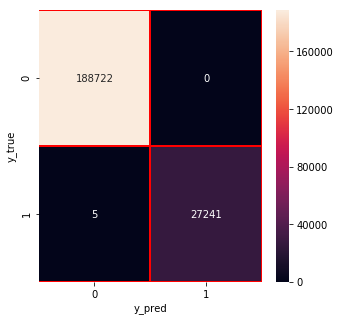

In [20]:
psrf_score,psrf_precision,psrf_recall,psrf_fscore,none=RandomForest(PS_X_train,PS_X_test,PS_y_train, PS_y_test)

Decision Tree Accuracy:0.9999351755815676
Decision Tree precision_recall_fscore:0.99993517558156760.99993517558156760.9999351755815676


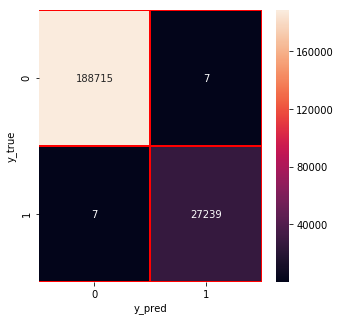

In [21]:
psdt_score,psdt_precision,psdt_recall,psdt_fscore,none=DecisionTree(PS_X_train,PS_X_test,PS_y_train, PS_y_test)

5 nn score:0.9953835753444955
5nn precision_recall_fscore:0.99538321526290120.99538357534449550.9953833941078519


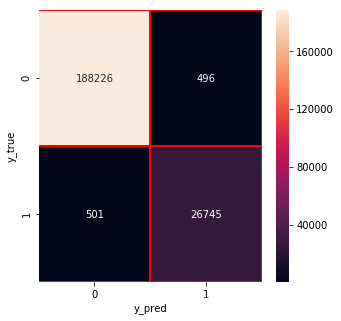

In [22]:
psKnn_score,psKnn_precision,psKnn_recall,psKnn_fscore,none=kNN(PS_X_train,PS_X_test,PS_y_train, PS_y_test)

In [ ]:
SVM(PS_X_train,PS_X_test,PS_y_train, PS_y_test)#svm de problem var

ANN accuracy:0.8738 

In [ ]:
ANN(PS_X_train,PS_X_test,PS_y_train, PS_y_test)

### DDoS ve BENIGN içeren dataframe için algorimalar:

Random Forest Accuracy:0.9999339582351879
Random Forest precision_recall_fscore:0.99993395765878170.99993395823518790.999933955153156


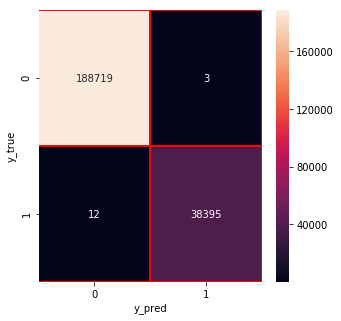

In [23]:
ddosrf_score,ddosrf_precision,ddosrf_recall,ddosrf_fscore,none=RandomForest(DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test)

Decision Tree Accuracy:0.9998591109017343
Decision Tree precision_recall_fscore:0.99985913240242860.99985911090173430.9998591182049291


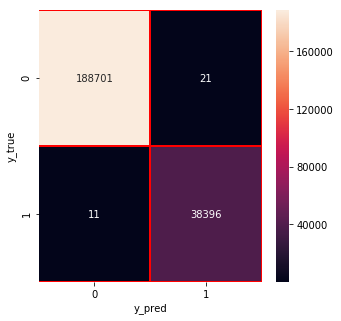

In [24]:
ddosdt_score,ddosdt_precision,ddosdt_recall,ddosdt_fscore,none=DecisionTree(DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test)

5 nn score:0.9992295127438592
5nn precision_recall_fscore:0.99923039066319210.99922951274385920.9992297880488104


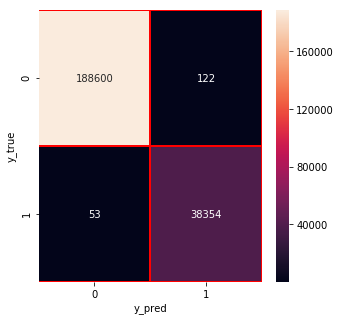

In [25]:
ddosKnn_score,ddosKnn_precision,ddosKnn_recall,ddosKnn_fscore,none=kNN(DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test)

In [ ]:
SVM(DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test)#svm de problem var

ANN accuracy:0.8307 

In [ ]:
ANN(DDoSX_train, DDoSX_test, DDoSy_train, DDoSy_test)

### Normal ve Anormal içeren dataframe için algorimalar:

Random Forest Accuracy:0.9995108195211786
Random Forest precision_recall_fscore:0.99951084634938970.99951081952117860.9995108272893927


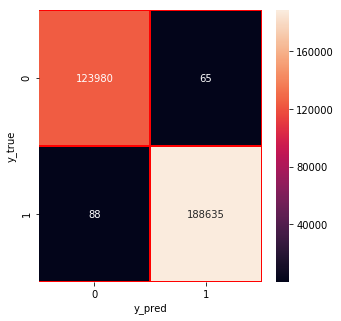

In [26]:
narf_score,narf_precision,narf_recall,narf_fscore,none=RandomForest(NA_X_train, NA_X_test, NA_y_train, NA_y_test)

Decision Tree Accuracy:0.9995587783916513
Decision Tree precision_recall_fscore:0.99955879360599380.99955877839165130.9995587832663996


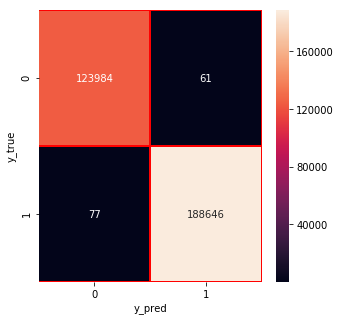

In [27]:
nadt_score,nadt_precision,nadt_recall,nadt_fscore,none=DecisionTree(NA_X_train, NA_X_test, NA_y_train, NA_y_test)

5 nn score:0.9919684878248414
5nn precision_recall_fscore:0.99197627961998680.99196848782484140.991970691849326


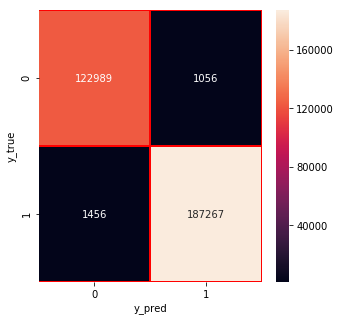

In [28]:
naKnn_score,naKnn_precision,naKnn_recall,naKnn_fscore,none=kNN(NA_X_train, NA_X_test, NA_y_train, NA_y_test)

In [ ]:
SVM(NA_X_train, NA_X_test, NA_y_train, NA_y_test) #svm de problem var

ANN accuracy:0.6034

In [ ]:
ANN(NA_X_train, NA_X_test, NA_y_train, NA_y_test)

## Accuracy tablosu

In [29]:
d={'Algoritmalar': ["Random Forest", "Decision Tree","KNN","ANN"], 
   'DoS accuracy': [dosrf_score,dosdt_score,dosKnn_score,0.7636],
   'DDoS accuracy': [ddosrf_score, ddosdt_score,ddosKnn_score,0.8307],
   'Port Scan accuracy':[psrf_score,psdt_score,psKnn_score,0.8738],
   'Normal/Anormal accuracy':[narf_score,nadt_score,naKnn_score,0.6034],
  }
dataframe= pd.DataFrame(data=d)
dataframe

,Algoritmalar,DoS accuracy,DDoS accuracy,Port Scan accuracy,Normal/Anormal accuracy
0,Random Forest,0.999272,0.999934,0.999977,0.999511
1,Decision Tree,0.999567,0.999859,0.999935,0.999559
2,KNN,0.994917,0.999230,0.995384,0.991968
3,ANN,0.763600,0.830700,0.873800,0.603400
